[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/tp/01_aprendizaje_supervisado/Enunciado.ipynb)

# Trabajo Práctico -  Aprendizaje supervisado
### Clasificación de expresiones genómicas

<span style="color: red;">**Fecha de entrega: Martes 08 de octubre del 2024 - hasta las 23:55hs.**

<span style="color: red;">**Fecha de entrega intermedia: Martes 01 de octubre del 2024 - hasta las 23:55hs.**
</span>

## Introducción

En el mundo actual, distintas disciplinas científicas empiezan, cada vez más, a interactuar con el fin de potenciar sus descubrimientos. En este caso dos grupos de investigación de [CONICET](https://www.conicet.gov.ar/) se embarcan en la combinación entre biología y informática para abordar la detección temprana y el pronóstico preciso de enfermedades como el cáncer. Este proyecto combina las tecnologías de secuenciación de nueva generación ([_NGS_](https://es.wikipedia.org/wiki/Secuenciaci%C3%B3n_paralela_masiva), por sus siglas en inglés) con la potencia de la inteligencia artificial. El enfoque se centra en un dataset único que abarca mediciones de [_ARN_](https://es.wikipedia.org/wiki/ARN_mensajero) de 200 [_genes_](https://es.wikipedia.org/wiki/Gen), recopiladas de pacientes con lesiones [_pre-tumorales_](https://en.wikipedia.org/wiki/Hyperplasia). Este conjunto de datos se convierte en una valiosa fuente de información para entender cómo las células en estado de hiperplasia pueden evolucionar hacia [_tumores malignos_](https://en.wikipedia.org/wiki/Neoplasm), una transformación que ha desconcertado a la ciencia durante décadas.

La hiperplasia, es un fenómeno en el que las células experimentan un crecimiento anormal y descontrolado, es un punto de partida crucial en nuestro análisis. ¿Cómo y por qué algunas células que experimentan hiperplasia se convierten en células cancerosas, mientras que otras no? Esta pregunta es el corazón de nuestra investigación. Para responderla se realizo un estudio donde se obtuvieron muestras de distintos tipos de hiperplasias de pacientes con antecedentes familiares y lesiones pre tumorales. Este grupo de pacientes, o cohorte, fue monitoreado periodicamente durante los siguientes 5 años buscando indicios de neoplasias o nuevas hiperplasias más agresivas. Con las muestras obtenidas en este estudio se realizo un [_biobanco_](https://en.wikipedia.org/wiki/Biobank) con las mediciones que habitualmente se hacen en la construccion de este tipo de [_plataformas_](https://xena.ucsc.edu/). Cada muestra fue etiquetada como **_buen pronostico_**, si no hubo indicios de nuevas hiperplasias o similares; contrariamente se etiquetaron como de **_mal pronostico_** si hubo una recaida.

Este trabajo se concentra en un panel de genes, especificamente en la expresion de 200 genes que se creen tienen un papel crucial en la transformacion tumoral y su etiqueta correspondiente.

En concreto:

Tendrán un archivo `.csv` en donde se almacenan:
  - una matriz de datos `X` de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$.
  - una columna llamada `target` que representa un vector de $500$ posiciones con dos posibles valores: `True` (ó 1, es decir, tiene mal pronostico) y `False` (ó 0, tiene buen pronostico).

Los datos están en esta [carpeta](https://github.com/aprendizaje-automatico-dc-uba-ar/material/tree/main/tp/01_aprendizaje_supervisado/datos).

Por otra parte, tendrán disponibles un conjunto de instancias sin etiquetas, que utilizaremos para comprobar la calidad de sus resultados (ver Ejercicio 5). 

**Recomendamos fuertemente leer primero todo el enunciado del trabajo antes de empezar a trabajar sobre el problema propuesto.**

---

### Sobre el informe

Para este trabajo deberán entregar, además del código de las pruebas y experimentos que realicen, un informe en el que deberan seleccionar, para cada apartado, sus resultados acompañado de un texto que explique, reflexione, justifique y conluya dicho contenido. 

Cada ejercicio indica el largo máximo del texto que se puede incluir. Los gráficos no están contados en dicho espacio. 
Cada gráfico incluido debe contar con:
  
  - nombres de los ejes,
  - título,
  - leyenda autocontenida,
  - debe ser referenciado desde el texto, ya que su inclusión se da porque aporta a la discusión del trabajo.

**El informe no puede superar un máximo de 8 carillas (contando gráficos) o 4 hojas más carátula.** No se corregirán trabajos que no cumplan con esta consigna.

---

## Ejercicio 1 

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. 

Evaluar y justificar cómo separarán sus datos para desarrollo y para evaluación. ¿Qué consideraciones tuvieron en cuenta para realizar esta división?

**Importante**: en este punto no está permitido dividir la base de datos utilizando la función `train_test_split` de sklearn. Deben decidir e implementar la separación.

In [1]:
#!pip install seaborn
#!pip install pandas
#!pip install matplotlib
#!pip install numpy

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import secrets
from typing import Tuple

In [3]:
df = pd.read_csv("data.csv")

En primer lugar vamos a ver la distribucion de las etiquetas y asegurar que los datos de desarrollo y evaluacion tengan las mismas proporciones

Cantidad de instancias positivas: 128 	Proporcion: 0.256
Cantidad de instancias negativas: 372 	Proporcion: 0.744


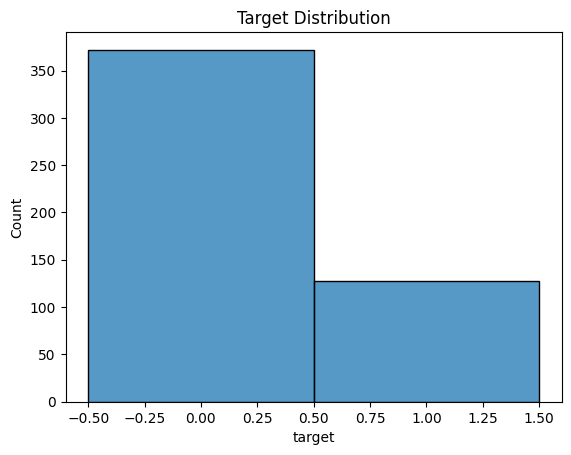

In [4]:
n_negativos = df[df["target"] == 0].shape[0]
n_positivos = df[df["target"] == 1].shape[0]
total = 500
print(f"Cantidad de instancias positivas: {n_positivos} \tProporcion: {n_positivos/total}")
print(f"Cantidad de instancias negativas: {n_negativos} \tProporcion: {n_negativos/total}")
plt.title("Target Distribution")
sns.histplot(data=df, x="target", discrete=True)
plt.show()

Como la distribucion de instancias positivas y negativas estan desbalanceadas, vamos a divir en desarrollo y evaluacion de manera estratificada, para matener dicha proporcion.

In [26]:
def corte_desarrollo_evaluacion_estratificada(df: pd.DataFrame, proporcion_desarrollo, seed)->Tuple[pd.DataFrame, pd.DataFrame]:

    # random generator
    rng = np.random.default_rng(secrets.randbits(128))

    # Separa entre instancias positivas y negativas
    df_negativos = df[df["target"] == 0]
    df_positivos = df[df["target"] == 1]
    
    # Calcula la cantidad de instacias positivas y negativos
    n_negativos = df_negativos.shape[0]
    n_positivos = df_positivos.shape[0]

    # Crea una mascara para selecionar las instancias negativas para desarrollo
    n_selec_negativos_desarrollo = round(n_negativos*proporcion_desarrollo)
    mascara_negativos_desarrollo = np.append(np.ones(n_selec_negativos_desarrollo, dtype = int), 
                                             np.zeros(n_negativos - n_selec_negativos_desarrollo, dtype = int))
    
    rng.shuffle(mascara_negativos_desarrollo)

    # Crea una mascara para selecionar las instancias positivas para desarrollo
    n_selec_positivos_desarrollo = round(n_positivos*proporcion_desarrollo)
    mascara_positivos_desarrollo = np.append(np.ones(n_selec_positivos_desarrollo, dtype = int), 
                                             np.zeros(n_positivos - n_selec_positivos_desarrollo, dtype = int))
    
    rng.shuffle(mascara_positivos_desarrollo)

    # Filtra las instacias para desarrollo
    df_desarrollo_negativos = df_negativos[mascara_negativos_desarrollo == 1]
    df_desarrollo_positivos = df_positivos[mascara_positivos_desarrollo == 1]

    # Filtra las instacias para evaluacion
    df_evaluacion_negativos = df_negativos[mascara_negativos_desarrollo == 0]
    df_evaluacion_positivos = df_positivos[mascara_positivos_desarrollo == 0]

    # Junta las instancias de desarrollo
    df_desarrollo = pd.concat([df_desarrollo_negativos,
                               df_desarrollo_positivos])
    
    df_desarrollo = df_desarrollo.sample(frac=1).reset_index(drop=True)
    
    # Junta las instacias de evaluacion
    df_evaluacion = pd.concat([df_evaluacion_negativos,
                               df_evaluacion_positivos])
    
    df_evaluacion = df_evaluacion.sample(frac=1).reset_index(drop=True)

    return df_desarrollo, df_evaluacion

df_desarrollo, df_evaluacion = corte_desarrollo_evaluacion_estratificada(df, 0.8, 1)

print("Desarrollo:")
display(df_desarrollo.head(3))
display(df_desarrollo.tail(3))

print("Evaluacion:")
display(df_evaluacion.head(3))
display(df_evaluacion.tail(3))

Desarrollo:


,IMzq,NuAg,FpJw,vilF,AKmi,BDfC,pDDY,znPg,VNds,eCei,...,kcQL,OHJK,zbGt,XzTy,uauW,xbpG,Nozi,jRec,MngL,target
0,4.637796,-0.103334,1.090845,-0.433278,-0.805229,0.835006,-0.512032,-4.026703,-0.879164,0.116055,...,-1.176806,0.344126,-0.342082,-0.878201,0.366078,-5.002009,-2.238465,1.168014,26.858023,0
1,-2.282709,-0.246966,0.632301,-0.929118,-0.215013,1.525542,-10.452672,-3.631342,0.318533,-1.775556,...,-1.247024,-3.967650,0.359515,0.145549,0.032431,33.750821,3.523611,-1.363925,-17.850522,1
2,-0.838270,2.196931,0.530446,-1.647826,-0.736814,-0.360158,-1.701270,0.816615,-0.176896,-0.242136,...,-5.796790,-1.527736,-0.441784,-1.601807,-0.125890,-7.763403,2.964217,-1.676581,0.155433,0


,IMzq,NuAg,FpJw,vilF,AKmi,BDfC,pDDY,znPg,VNds,eCei,...,kcQL,OHJK,zbGt,XzTy,uauW,xbpG,Nozi,jRec,MngL,target
397,0.789941,-1.736662,0.942608,-1.761123,-0.157528,-0.062544,1.911366,3.642690,-1.386295,-3.767767,...,0.532650,-0.813094,0.984430,0.712501,1.225815,-18.864725,-1.069636,-0.601454,-4.208533,0
398,0.334710,2.182461,0.676405,0.830728,-1.764537,-2.029737,3.242517,2.945435,-0.958737,-9.335921,...,1.988188,0.922776,-0.527066,0.470165,-0.768502,-5.051181,-2.741439,0.742984,14.223794,0
399,4.911136,-0.060886,-1.523823,-0.081124,0.875286,0.231523,0.104020,6.029012,0.950380,5.279417,...,9.906167,0.945208,1.094759,-3.708474,0.576785,11.130038,-1.899010,0.572146,-22.940880,0


Evaluacion:


,IMzq,NuAg,FpJw,vilF,AKmi,BDfC,pDDY,znPg,VNds,eCei,...,kcQL,OHJK,zbGt,XzTy,uauW,xbpG,Nozi,jRec,MngL,target
0,-4.805237,-0.570818,0.056472,-0.107008,-0.798590,-1.497650,-0.499398,-1.893610,0.459474,0.474703,...,0.325426,-2.920242,-0.955129,0.545157,0.453285,-3.549592,2.590488,0.675621,10.636347,1
1,-2.257715,1.278235,-1.939611,-1.393045,1.397257,-0.468588,0.223386,-4.454691,1.029189,4.016885,...,2.085339,0.791617,-0.962017,-1.035253,0.705881,5.031821,4.909369,1.185415,-4.339819,1
2,-1.185105,-0.358585,0.702129,1.346105,-0.927821,-2.027030,0.055749,-0.776307,-0.083317,1.909196,...,-2.357380,-0.078625,0.746811,-1.500347,0.967231,23.858341,0.479027,1.076254,13.807201,1


,IMzq,NuAg,FpJw,vilF,AKmi,BDfC,pDDY,znPg,VNds,eCei,...,kcQL,OHJK,zbGt,XzTy,uauW,xbpG,Nozi,jRec,MngL,target
97,1.889742,-0.113575,0.675807,-0.850707,0.282124,0.381229,1.062542,-2.140246,0.431692,1.161266,...,2.616953,3.629272,-0.080904,2.086725,0.869109,11.600961,-2.306325,-2.040486,-11.208306,1
98,-1.533137,0.213518,-2.245017,0.464949,0.806434,3.063420,2.741483,2.509536,1.484036,0.698900,...,1.612858,0.736861,-0.965585,1.974084,0.023283,-4.108870,-0.646664,0.123585,-12.835991,1
99,-5.071674,0.105958,-1.816341,-1.276827,-0.810685,-0.920079,-1.159566,0.928324,-0.128274,1.983135,...,-3.023890,-3.174092,-0.886526,0.215515,-0.882403,7.301237,1.633070,-2.049416,-17.832163,0


## Ejercicio 2


### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo **árbol de decisión**. Además, obtener una **estimación realista de la performance** de los mismos.

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default.

1. Estimar la performance del modelo utilizando _K-fold cross validation_ con `K=5`, con las métricas _Accuracy_, _Area Under the Precision-Recall Curve (AUPRC)_, y _Area Under the Receiver Operating Characteristic Curve (AUCROC)_. 

   En esta oportunidad se va a pedir además de calcular las métricas para cada fold por separado y su promedio, que hagan el cálculo del score global (como vimos en clase), sólo para los folds de validación.
   
   Reportar el resultado en una tabla similar a:

      <table>
      <thead>
      <tr>
      <th align="center">Permutación</th>
      <th>Accuracy (training)</th>
      <th>Accuracy (validación)</th>
      <th>AUPRC (training)</th>
      <th>AUPRC (validación)</th>
      <th>AUC ROC (training)</th>
      <th>AUC ROC (validación)</th>
      </tr>
      </thead>
      <tbody>
      <tr>
      <td align="center">1</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">2</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">3</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">4</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">5</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">Promedios</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <td align="center">Global</td>
      <td>(NO) </td>
      <td></td>
      <td>(NO) </td>
      <td></td>
      <td>(NO) </td>
      <td></td>
      </tr>
      </tbody>
      </table>    
  
   **Importante**: de acá en más sólamente utilizaremos el score promedio cuando hagamos _K-fold cross-validation_.
 
1. Explorar las siguientes combinaciones de parámetros para  árboles de decisión (siguiendo con $k-fold$ con $k=5$) utilizando [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) de _scikit learn_. No está permitido utilizar `GridSearchCV` en este ejercicio.

   <table>
   <thead>
   <tr>
   <th align="center">Altura máxima</th>
   <th align="center">Criterio de corte</th>
   <th>Accuracy (training)</th>
   <th>Accuracy (validación)</th>
   </tr>
   </thead>
   <tbody><tr>
   <td align="center">3</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">3</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   </tbody></table>

1. ¿Qué conclusiones se pueden sacar de estas tablas?  

## Ejercicio 3

### Comparación de algoritmos 

Se pide explorar distintas combinaciones de algoritmos de aprendizaje con diferentes configuraciones con el objetivo de **encontrar el mejor modelo** de cada familia de buscar la performance óptima. Para este ejercicio realizar una experimentación utilizando [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Como métrica de performance usar AUCROC resultante de 5-fold cross-validation. 

Hiperparámetros_: Revisar la documentación de cada uno de los hiperparámetros para entender qué posibles hiperparámetros impacten de manera positiva en la construcción del algoritmo.

Documentación extra sobre [`Tuning hyper-parameters`](https://scikit-learn.org/stable/modules/grid_search.html), leer hasta 3.2.2.

1. Algoritmos a probar: 
  - Árboles de decisión. Mínimo 4 hiperparámetros.
  - KNN (k-vecinos más cercanos). Mínimo 3 hiperparámetros.
  - SVM (Support vector machine). Mínimo 2 hiperparámetros.

Detallar los hiperparámetros elegidos para cada algoritmo y explicar la razón del espacio de búsqueda considerado para cada uno de estos, ¿cuántas iteraciones usaron?. A su vez, reportar la performance asociada de aquellos que consideren relevantes (al menos la mejor combinación para cada algoritmo). 

2. Compare los resultados obtenidos en el ejercicio anterior con los siguientes modelos con sus hiperparámetros default. 

  - LDA (Linear discriminant analysis)
  - Naïve Bayes

¿Qué resultados obtuvo? ¿Qué hiperparámetros podrían ser relevantes explorar en estos modelos? ¿Por qué?

3. ¿Cuál fue el mejor modelo y con qué configuración? Explicar por qué creería que dio mejor (recordando qué hace cada algoritmo y con qué tipo de datos están trabajando).

## Ejercicio 4
### Diagnóstico Sesgo-Varianza.

<span style="color: red;">(no realizar hasta la clase _Sesgo y Varianza_)</span>

En este punto, se pide inspeccionar **tres** de sus mejores modelos encontrados hasta ahora de cada familia de modelos: la mejor configuración para el árbol de decisión y la mejor configuración para SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo pero ahora incluya LDA. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo **RandomForest** con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos.


**Atención**: Tener en cuenta que debemos seguir utilizando AUC ROC como métrica para estas curvas.


## Ejercicio 5: 
### Evaluación de performance

- La entrega del trabajo estará acompañada de una evaluación en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

- Su tarea será estimar la performance (AUCROC) que tendrá su mejor modelo en datos de evaluación (X_held_out). 

- Para ello, deberán predecir las **probabilidades** de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUCROC resultante y calcularemos el resultado real. Consideraremos que el **mejor modelo será el que se encuentre más cerca del valor real que calcularemos luego de la entrega**.

- Recomendamos no perder de vista esta evaluación/competencia durante el desarrollo del TP, sobretodo en el momento de separar los datos en los primeros puntos. 

- Para que podamos evaluar la performance, junto con la entrega del informe, deberán enviar un archivo con el numero de grupo con dos digitos en formato csv con la columna `output` y el valor obtenido con 4 decimales (se subirá un ejemplo cuando se publiquen los datos de la competencia) y un valor esperado de AUCROC: `GG_y_pred_held_out_AUCROC`. 

    - Ej.: el grupo tres cree que obtuvo un valor de 0.7321 de AUCROC deberá submitear un archivo llamado: `03_y_pred_held_out_7321.csv`.

- Los datos podrán encontrarlos en este [link](https://github.com/aprendizaje-automatico-dc-uba-ar/material/tree/main/tp/01_aprendizaje_supervisado/datos).

- Las decisiones de este punto pueden desarrollarse hasta en una carilla, aunque con media debería alcanzar.


## Ejercicio 6: 
### Conclusiones

Escribir como mínimo en un párrafo, una conclusión del trabajo realizado, incluyendo problemas encontrados y 
aspectos no incluidos en el enunciado que hayan sido abordadas durante el desarrollo.

---
## Entregables
- Contarán con un esqueleto en formato Jupyter Notebook en donde podrán intercalar celdas para reportar y responder a los ítems de cada ejercicio. 
- Los entregrables serán
    - Un informe en formato .pdf (**digital**) que responda a los ítems de este enunciado respetando la cantidad de espacio máximo por cada ítem. Nombrarlo siguiendo el formato `GG_Nombre_de_grupo`
    - Adjuntar el notebook final en formatos .pdf e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (verificarlo haceindo: Kernel -> Restart and Run All). 
    - Las predicciones del *held out* del punto 5 en formato csv.
- Habŕa una entrega intermedia obligatoria que deberán hacer antes del 01 de octubre de 2024 a las 23:55hs. Para esta entrega deberán enviar el código que resuelve los primeros 3 ejercicios. 
- La **fecha** y **hora límite** de entrega está determinada en el campus de la materia.
- El trabajo deberá elaborarse en grupos de hasta 3 personas (3 preferentemente).
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.


### Importante: sobre el uso de ChatGPT y grandes modelos de lenguaje

En este trabajo no estará explícitamente prohibido pero si fuertemente desaconsejado, consideramos a este trabajo práctico una importante herramienta de aprendizaje donde el uso de GPT puede ser perjudicial. En caso de usarlo se pide aclararlo en el informe y especificar cómo y en donde se utilizó. Así como expresar su opinión sobre la respuesta generada por el modelo pudiendo estar a favor o en contra de lo propuesto por este. Pueden adjuntar el link a la conversación con el modelo.

**Nota**: Agradecemos a [Martín García Sola](https://ar.linkedin.com/in/martin-e-garcia-sola) por la asistencia biológica en la confección de este Trabajo Práctico.